In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### <span style = 'background-color:LightBlue'> Simulated Stock Trade Times using Hawkes Process </span>

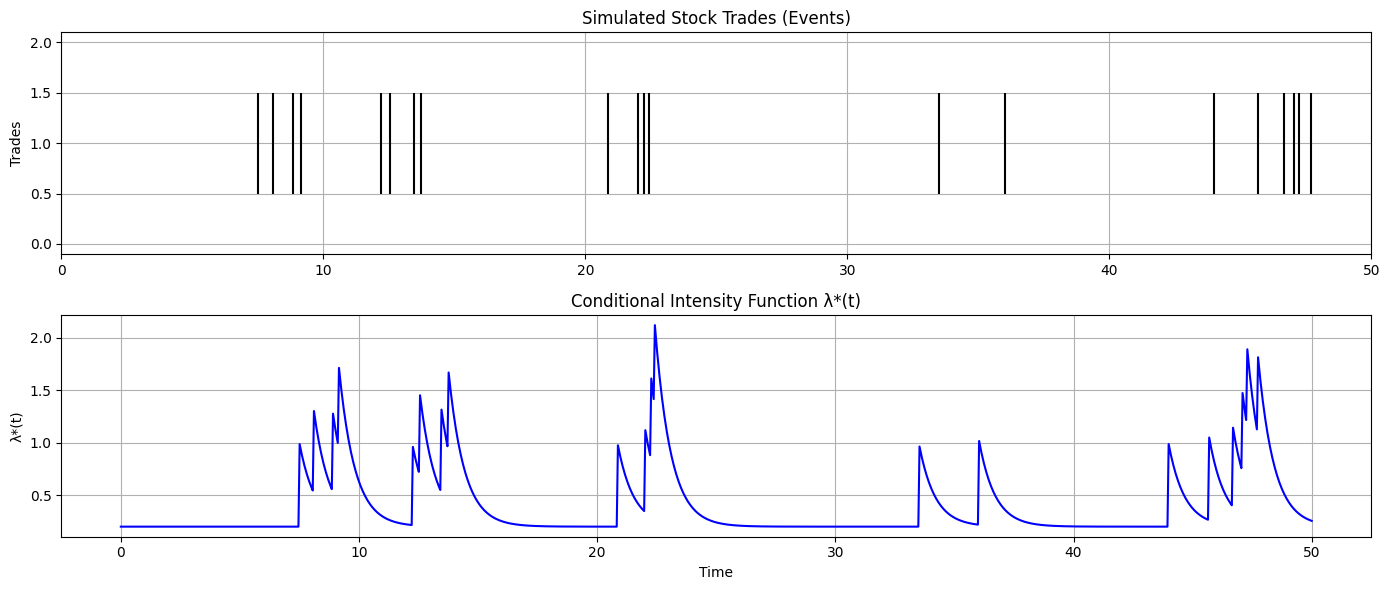

In [2]:
# Parameters of the Hawkes Process

#Backgound Intensity
lambda0 = 0.2          
# Excitation per event
alpha = 0.8            
# Decay rate
beta = 1.5             
# Total time
T = 50                 

np.random.seed(16)     

# Simulate Hawkes Process using thinning (Ogata's thinning method https://stmorse.github.io/journal/Hawkes-python.html)
def simulate_hawkes(lambda0, alpha, beta, T):
    t = 0
    events = []

    lambda_t = lambda0
    while t < T:
        # upper bound for thinning
        lambda_bar = lambda0 + np.sum([alpha * np.exp(-beta * (t - ti)) for ti in events])
        u = np.random.uniform()
        w = -np.log(u) / lambda_bar
        t += w

        if t > T:
            break

        lambda_actual = lambda0 + np.sum([alpha * np.exp(-beta * (t - ti)) for ti in events])
        D = np.random.uniform()
        if D <= lambda_actual / lambda_bar:
            events.append(t)

    return np.array(events)

# Compute conditional intensity λ*(t) at dense time grid
def compute_intensity(t_grid, events, lambda0, alpha, beta):
    intensities = np.zeros_like(t_grid)
    for i, t in enumerate(t_grid):
        intensities[i] = lambda0 + np.sum([alpha * np.exp(-beta * (t - ti)) for ti in events if ti < t])
    return intensities

# Simulate the process
event_times = simulate_hawkes(lambda0, alpha, beta, T)
t_grid = np.linspace(0, T, 1000)
intensity = compute_intensity(t_grid, event_times, lambda0, alpha, beta)

# Plot
plt.figure(figsize=(14, 6))

# Events
plt.subplot(2, 1, 1)
plt.eventplot(event_times, lineoffsets=1, colors='black')
plt.xlim([0, T])
plt.title("Simulated Stock Trades (Events)")
plt.ylabel("Trades")
plt.grid(True)

# Conditional Intensity
plt.subplot(2, 1, 2)
plt.plot(t_grid, intensity, color='blue')
plt.title("Conditional Intensity Function λ*(t)")
plt.xlabel("Time")
plt.ylabel("λ*(t)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [3]:
# Load May 19 AAPL Data 
file_path = r"C:\\Users\\ershf\\Documents\\Curvature_Stock_data\\pandas_df_0519.csv"
df = pd.read_csv(file_path, usecols=['ticker', 'close_ts', 'price', 'ln_price'])

In [4]:
df.head()

,ticker,close_ts,price,ln_price
0,AAPL,2025-05-19 13:30:01.261632,207.99,5.33749
1,AAPL,2025-05-19 13:30:01.268000,207.99,5.33749
2,AAPL,2025-05-19 13:30:01.269000,207.99,5.33749
3,AAPL,2025-05-19 13:30:01.270000,207.99,5.33749
4,AAPL,2025-05-19 13:30:01.278000,207.99,5.33749


In [5]:
base_path = r"C:\Users\ershf\Documents\Curvature_Stock_data"
days = ['0519', '0520', '0521', '0522', '0523']

file_path = os.path.join(base_path, f"pandas_df_0520.csv")
df = pd.read_csv(file_path, parse_dates=['close_ts'])
df.head()

,ticker,close_ts,price,ln_price,log_return
0,AAPL,2025-05-20 13:30:00.099559,207.67,5.335950,NaN
1,AAPL,2025-05-20 13:30:00.100520,207.71,5.336143,1.000036
2,AAPL,2025-05-20 13:30:00.100564,207.68,5.335998,0.999973
3,AAPL,2025-05-20 13:30:00.146682,207.67,5.335950,0.999991
4,AAPL,2025-05-20 13:30:00.146709,207.67,5.335950,1.000000


In [6]:
df_aapl = df[df['ticker']=='AAPL'].sort_values("close_ts")
start_time = df_aapl['close_ts'].min()
event_times = (df_aapl['close_ts'] - start_time).dt.total_seconds().values

In [7]:
df_aapl

,ticker,close_ts,price,ln_price,log_return
0,AAPL,2025-05-20 13:30:00.099559,207.6700,5.335950,NaN
1,AAPL,2025-05-20 13:30:00.100520,207.7100,5.336143,1.000036
2,AAPL,2025-05-20 13:30:00.100564,207.6800,5.335998,0.999973
3,AAPL,2025-05-20 13:30:00.146682,207.6700,5.335950,0.999991
4,AAPL,2025-05-20 13:30:00.146709,207.6700,5.335950,1.000000
...,...,...,...,...,...
15881,AAPL,2025-05-20 19:59:42.191558,206.8443,5.331966,0.999963
15882,AAPL,2025-05-20 19:59:47.979532,206.8722,5.332101,1.000025
15883,AAPL,2025-05-20 19:59:55.109471,206.8511,5.331999,0.999981
15884,AAPL,2025-05-20 19:59:58.263161,206.8910,5.332192,1.000036


### <span style = 'background-color:LightBlue'> Fitting Hawkes Process Manually to log returns </span>

We will be fitting Hawkes Process to the log_returns on AAPL high frequency stock prices manually. First let's go over the formula we will be coding.

First we assume an exponential kernel Hawkes process and recall the formula. 
$$ \lambda(t) = \mu + \sum_{t_i < t} \alpha e^{-\beta{(t-t_{i}})}$$

where 

$\bullet \mu$ : base intensity (background Poisson component)

$\bullet \alpha$ : excitation magnitude

$\bullet \beta$ : decay rate

**Log-likelihood of the Hawkes process :** Let $\{t_1, t_2, \dots t_n \}$ be event times, and $T$ the observation window, then

$$ \mathcal{L} = \sum_{i=1}^{n} \lambda (t_i) -\int_{0}^{T}\lambda (s) ds$$

which becomes,

$$ \mathcal{L} = \sum_{i=1}^{n} \log \Big( \mu + \sum_{t_j < t_i} \alpha e^{-\beta{(t_i-t_{j}})} \Big) - \mu T - \frac{\alpha}{\beta} \sum_{i=1}^{n} \big( 1 - e^{- \beta{(T-t_i)}} \big)$$

This formula is what we need to code from scratch.

Estimated Parameters:
μ = 0.0360, α = 0.0684, β = 0.0903


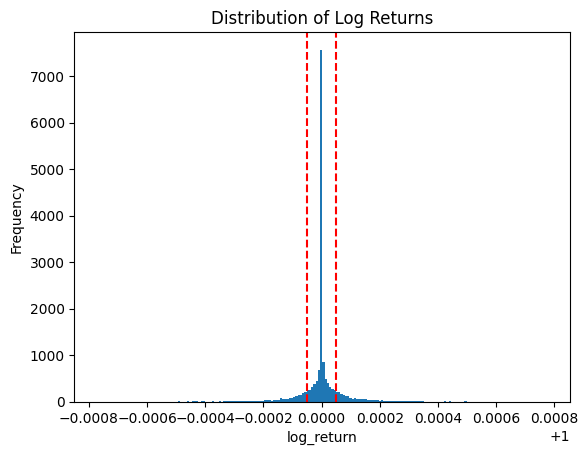

In [8]:
from scipy.optimize import minimize

# Use large log returns as events (threshold-based)
threshold = .00005
event_mask = np.abs(df_aapl['log_return'] - 1) > threshold
event_times = df_aapl['close_ts'][event_mask].values.astype('datetime64[ns]')

# Convert to seconds since start
event_seconds = (event_times - event_times[0]) / np.timedelta64(1, 's')
T = (df_aapl['close_ts'].iloc[-1] - event_times[0]) / np.timedelta64(1, 's')
n = len(event_seconds)

def log_likelihood(params):
    mu, alpha, beta = params
    if mu <= 0 or alpha <= 0 or beta <= 0:
        return np.inf

    ll = 0
    for i in range(n):
        intensity = mu + np.sum(alpha * np.exp(-beta * (event_seconds[i] - event_seconds[:i])))
        if intensity <= 0:
            return np.inf
        ll += np.log(intensity)

    comp1 = mu * T
    comp2 = (alpha / beta) * np.sum(1 - np.exp(-beta * (T - event_seconds)))
    return -(ll - comp1 - comp2)  # Negative for minimization

# Initial guess
initial_params = [0.1, 0.5, 1.0]
bounds = [(1e-6, None), (1e-6, None), (1e-6, None)]

result = minimize(log_likelihood, initial_params, bounds=bounds, method='L-BFGS-B')

mu_hat, alpha_hat, beta_hat = result.x
print("Estimated Parameters:")
print(f"μ = {mu_hat:.4f}, α = {alpha_hat:.4f}, β = {beta_hat:.4f}")

plt.hist(df_aapl["log_return"].dropna(), bins=200)
plt.axvline(1 + threshold, color='r', linestyle='--')
plt.axvline(1 - threshold, color='r', linestyle='--')
plt.title("Distribution of Log Returns")
plt.xlabel("log_return")
plt.ylabel("Frequency")
plt.show()


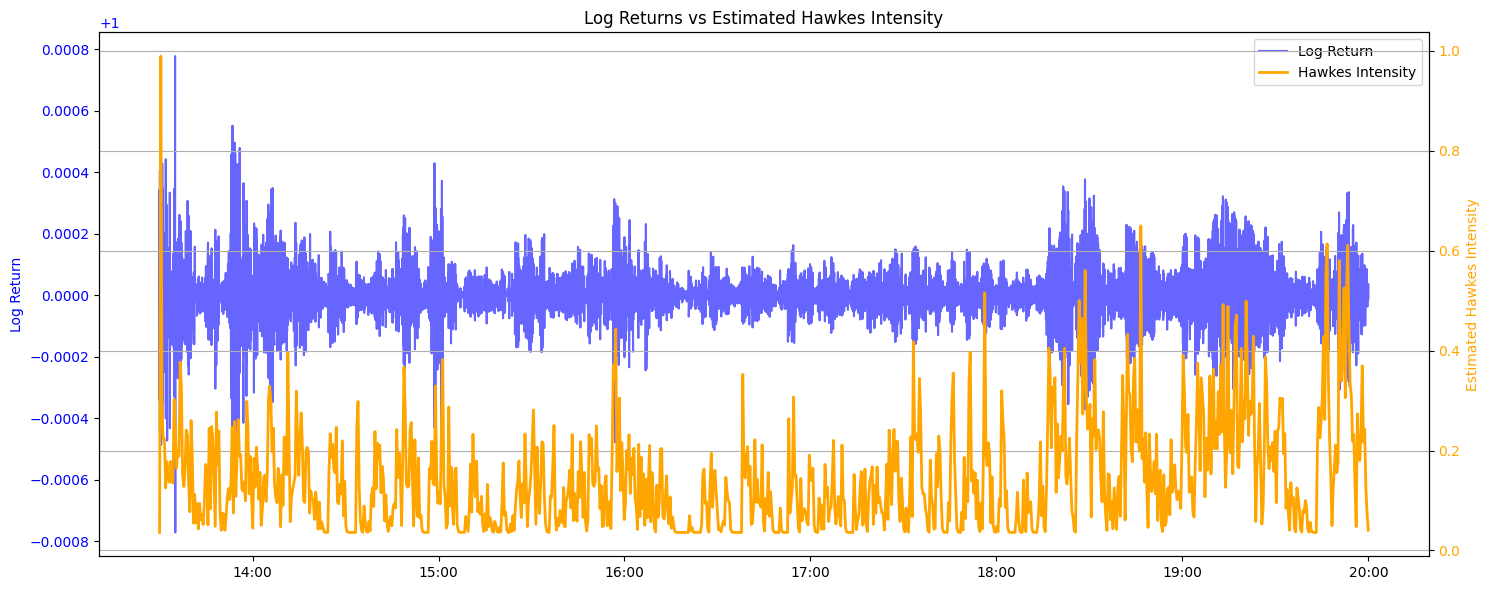

In [18]:
import matplotlib.dates as mdates

# Estimated parameters from your MLE
mu = mu_hat
alpha = alpha_hat
beta = beta_hat

# Define the grid of time points (in seconds since start)
grid = np.linspace(0, T, 1000)

# Compute conditional intensity at each time point in grid
intensity = np.array([
    mu + np.sum(alpha * np.exp(-beta * (t - event_seconds[event_seconds < t])))
    for t in grid
])

# Convert grid back to datetime for plotting
start_ts = df_aapl['close_ts'][event_mask].iloc[0]
intensity_timestamps = start_ts + pd.to_timedelta(grid, unit='s')

# ─────────────── Plotting ─────────────── #
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_title("Log Returns vs Estimated Hawkes Intensity")

# Log return plot
ax1.plot(df_aapl['close_ts'], df_aapl['log_return'], label='Log Return', color='blue', alpha=0.6)
ax1.set_ylabel('Log Return', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Hawkes intensity plot on secondary axis
ax2 = ax1.twinx()
ax2.plot(intensity_timestamps, intensity, label='Hawkes Intensity', color='orange', linewidth=2)
ax2.set_ylabel('Estimated Hawkes Intensity', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()


Next we plot the conditional intensity. 

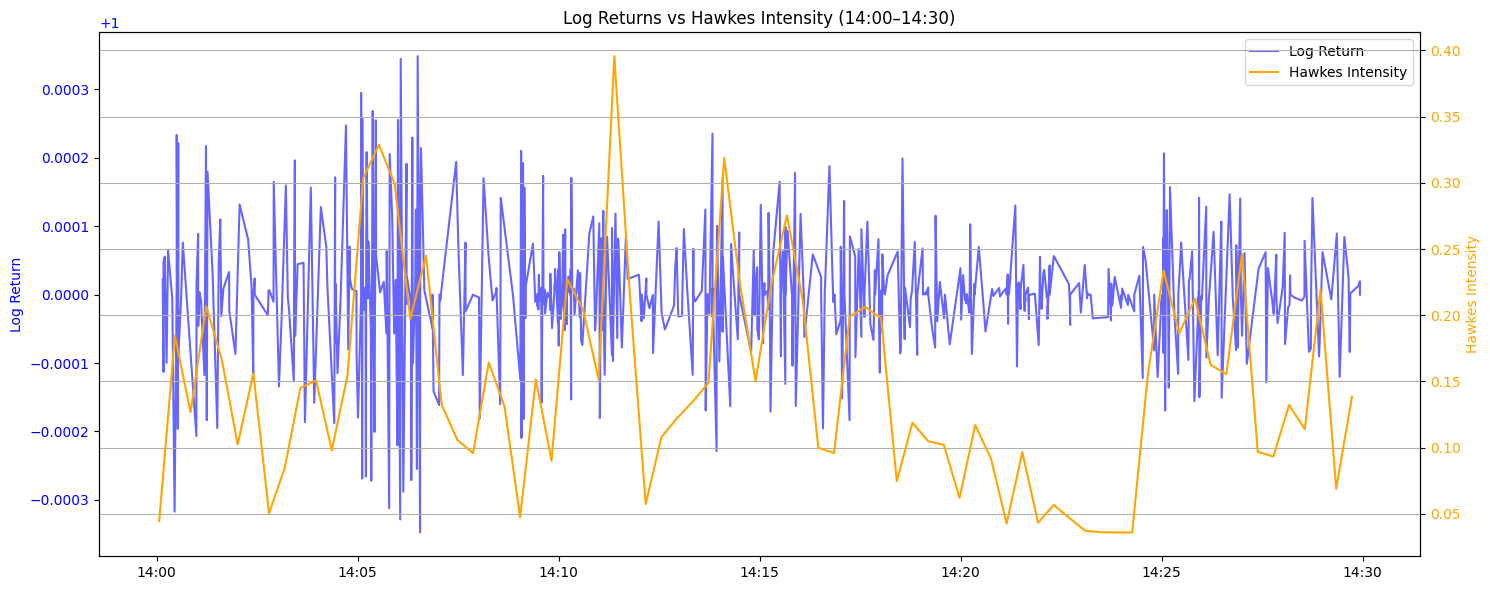

In [19]:
# Define your window (e.g., between 14:00 and 14:30)
start_time = pd.to_datetime('2025-05-20 14:00:00')
end_time = pd.to_datetime('2025-05-20 14:30:00')

# Filter AAPL log return data
mask = (df_aapl['close_ts'] >= start_time) & (df_aapl['close_ts'] <= end_time)
df_window = df_aapl.loc[mask]

# Filter intensity grid to same window
intensity_mask = (intensity_timestamps >= start_time) & (intensity_timestamps <= end_time)
intensity_window = np.array(intensity)[intensity_mask]
intensity_time_window = intensity_timestamps[intensity_mask]


fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_title("Log Returns vs Hawkes Intensity (14:00–14:30)")

# Log return (windowed)
ax1.plot(df_window['close_ts'], df_window['log_return'], label='Log Return', color='blue', alpha=0.6)
ax1.set_ylabel('Log Return', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Intensity (secondary axis)
ax2 = ax1.twinx()
ax2.plot(intensity_time_window, intensity_window, label='Hawkes Intensity', color='orange')
ax2.set_ylabel('Hawkes Intensity', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()



**Next let's actually predict and compare**

In [80]:
%%time 

import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import arviz as az

# ─────────────── Step 1: Define Hawkes Simulator ─────────────── #
def simulate_hawkes(mu, alpha, beta, T):
    times = []
    t = 0
    while t < T:
        λ = mu + np.sum(alpha * np.exp(-beta * (t - np.array(times))))
        u = np.random.uniform()
        w = -np.log(u) / λ
        t += w
        D = np.random.uniform()
        times_array = np.array(times)
        actual_λ = mu + np.sum(alpha * np.exp(-beta * (t - times_array[times_array < t])))
        if D <= actual_λ / λ and t < T:
            times.append(t)
    return np.array(times)

# ─────────────── Step 2: Load AAPL Data ─────────────── #

df_aapl['timestamp'] = pd.to_datetime(df_aapl['timestamp'])
start_time = df_aapl['timestamp'].iloc[0]
df_aapl['seconds_since_start'] = (df_aapl['timestamp'] - start_time).dt.total_seconds()

T_max = df_aapl['seconds_since_start'].iloc[-1]

# ─────────────── Step 3: Simulate Synthetic Hawkes Events ─────────────── #
np.random.seed(42)
event_times = simulate_hawkes(mu=0.3, alpha=0.7, beta=1.5, T=T_max)

# ─────────────── Step 4: PyMC Inference ─────────────── #
with pm.Model() as hawkes_model:
    mu = pm.HalfNormal("mu", sigma=1.0)
    alpha = pm.HalfNormal("alpha", sigma=1.0)
    beta = pm.HalfNormal("beta", sigma=1.0)

    t_obs = pt.as_tensor_variable(event_times)

    def intensity(ti, mu, alpha, beta, t_hist):
        mask = t_hist < ti
        delta = ti - t_hist[mask]
        return mu + pt.sum(alpha * pt.exp(-beta * delta))

    λ_t = []
    for i in range(len(event_times)):
        t_i = event_times[i]
        hist = event_times[:i]
        λ_i = intensity(t_i, mu, alpha, beta, pt.as_tensor_variable(hist))
        λ_t.append(λ_i)

    log_intensity = pt.sum(pt.log(pt.stack(λ_t)))

    def compensator(t, mu, alpha, beta, t_hist):
        return mu * t + pt.sum((alpha / beta) * (1 - pt.exp(-beta * (t - t_hist[t_hist < t]))))

    integral = compensator(T_max, mu, alpha, beta, pt.as_tensor_variable(event_times))
    log_likelihood = log_intensity - integral
    pm.Potential("likelihood", log_likelihood)

    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)

# ─────────────── Step 5: Plot Posterior ─────────────── #
az.plot_trace(trace, var_names=["mu", "alpha", "beta"])
plt.tight_layout()
plt.show()

# ─────────────── Step 6: Compute Intensity Grid ─────────────── #
def compute_intensity_grid(grid, event_times, mu, alpha, beta):
    intensities = []
    for t in grid:
        past_events = event_times[event_times < t]
        intensity = mu + np.sum(alpha * np.exp(-beta * (t - past_events)))
        intensities.append(intensity)
    return np.array(intensities)

# Use posterior sample to get mu, alpha, beta
posterior_sample = trace.posterior.stack(samples=("chain", "draw"))
mu_post = posterior_sample["mu"].values[0]
alpha_post = posterior_sample["alpha"].values[0]
beta_post = posterior_sample["beta"].values[0]

# Simulate events again using posterior values
event_times_rescaled = simulate_hawkes(mu_post, alpha_post, beta_post, T_max)

# Compute intensity at each AAPL timestamp
grid = df_aapl['seconds_since_start'].values
intensity_values = compute_intensity_grid(grid, event_times_rescaled, mu_post, alpha_post, beta_post)

# ─────────────── Step 7: Plot Log Return vs Intensity ─────────────── #
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_title("AAPL Log Returns vs Hawkes Intensity")
ax1.plot(df_aapl['timestamp'], df_aapl['log_return'], label='Log Return', color='blue', alpha=0.6)
ax1.set_ylabel('Log Return', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax2 = ax1.twinx()
ax2.plot(df_aapl['timestamp'], intensity_values, label='Hawkes Intensity', color='orange')
ax2.set_ylabel('Hawkes Intensity', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

Estimated Parameters:
μ = 0.1846, α = 0.1694, β = 0.4451


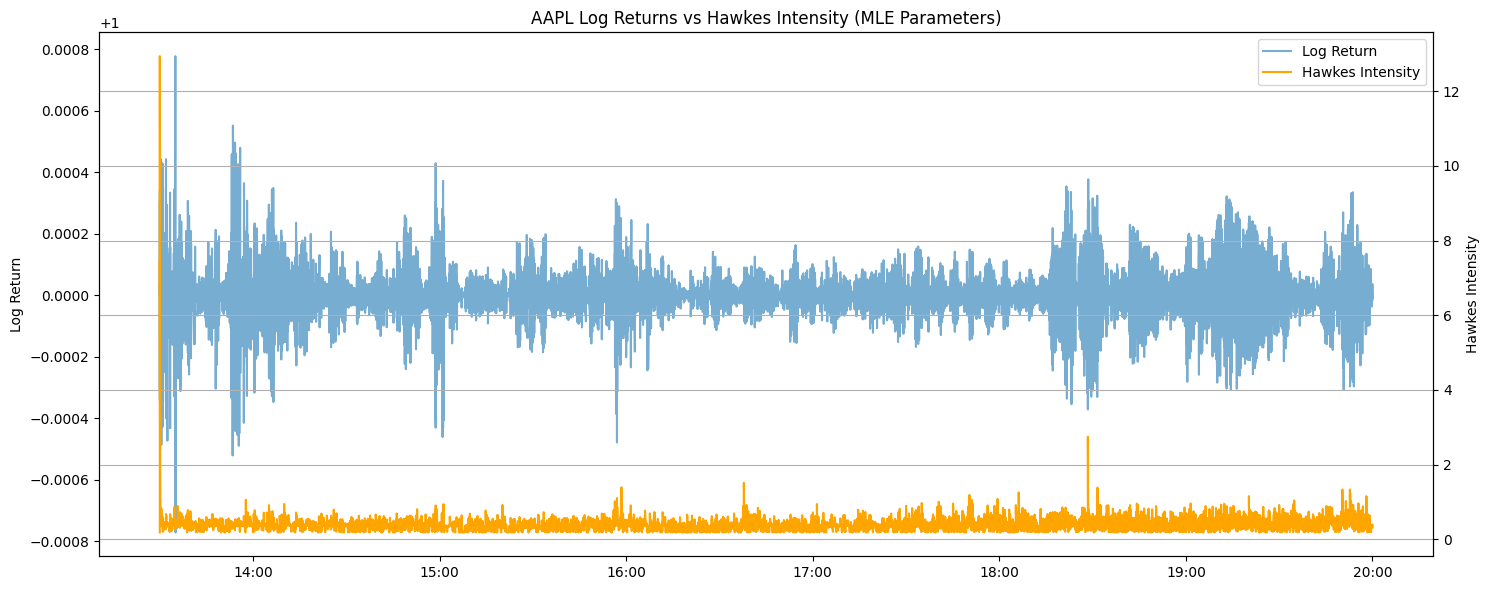

CPU times: total: 1min 48s
Wall time: 1min 52s


In [109]:
%%time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import minimize

# ─────────────── 1. Load AAPL Data ─────────────── #
df = df_aapl.copy()
df['timestamp'] = pd.to_datetime(df['timestamp']) if 'timestamp' in df else pd.to_datetime(df['close_ts'])
df = df.sort_values('timestamp', kind='mergesort').reset_index(drop=True)

start_time = df['timestamp'].iloc[0]
df['seconds_since_start'] = (df['timestamp'] - start_time).dt.total_seconds().astype('float64')
T_max = df['seconds_since_start'].iloc[-1]
grid = df['seconds_since_start'].to_numpy(dtype=float)

# ─────────────── 2. Detect Large Events ─────────────── #
threshold = 0.00001
event_mask = np.abs(df['log_return'] - 1) > threshold
event_times = df['seconds_since_start'][event_mask].values.astype(float)
T = T_max
n = len(event_times)

# ─────────────── 3. MLE: Log-Likelihood Function ─────────────── #
def neg_loglik(params):
    mu, alpha, beta = params
    if mu <= 0 or alpha <= 0 or beta <= 0:
        return np.inf
    ll = 0.0
    for i in range(n):
        past_events = event_times[:i]
        intensity = mu + np.sum(alpha * np.exp(-beta * (event_times[i] - past_events)))
        if intensity <= 0:
            return np.inf
        ll += np.log(intensity)
    comp1 = mu * T
    comp2 = (alpha / beta) * np.sum(1 - np.exp(-beta * (T - event_times)))
    return -(ll - comp1 - comp2)

# ─────────────── 4. Optimize Parameters ─────────────── #
initial_params = [0.1, 0.5, 1.0]
bounds = [(1e-6, None), (1e-6, None), (1e-6, None)]
result = minimize(neg_loglik, initial_params, bounds=bounds, method='L-BFGS-B')
mu_hat, alpha_hat, beta_hat = result.x

print(f"Estimated Parameters:\nμ = {mu_hat:.4f}, α = {alpha_hat:.4f}, β = {beta_hat:.4f}")

# ─────────────── 5. Compute Intensity on Grid (Linear Time) ─────────────── #
def intensity_on_grid_linear(grid, events, mu, alpha, beta):
    grid = np.asarray(grid, dtype=float)
    events = np.asarray(events, dtype=float)
    intens = np.empty_like(grid, dtype=float)
    i_g, i_e = 0, 0
    m = 0.0
    last_t = 0.0
    while i_g < len(grid) or i_e < len(events):
        next_g = grid[i_g] if i_g < len(grid) else np.inf
        next_e = events[i_e] if i_e < len(events) else np.inf
        if next_e <= next_g:
            dt = max(0.0, next_e - last_t)
            m *= np.exp(-beta * dt)
            m += alpha
            last_t = next_e
            i_e += 1
        else:
            dt = max(0.0, next_g - last_t)
            m *= np.exp(-beta * dt)
            intens[i_g] = mu + m
            last_t = next_g
            i_g += 1
    return intens

intensity_values = intensity_on_grid_linear(grid, event_times, mu_hat, alpha_hat, beta_hat)

# ─────────────── 6. Plot: Log Returns + Hawkes Intensity ─────────────── #
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_title("AAPL Log Returns vs Hawkes Intensity (MLE Parameters)")
ax1.plot(df['timestamp'], df['log_return'], label='Log Return', alpha=0.6)
ax1.set_ylabel('Log Return')
ax1.tick_params(axis='y')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax2 = ax1.twinx()
ax2.plot(df['timestamp'], intensity_values, label='Hawkes Intensity', color='orange')
ax2.set_ylabel('Hawkes Intensity')
ax2.tick_params(axis='y')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()


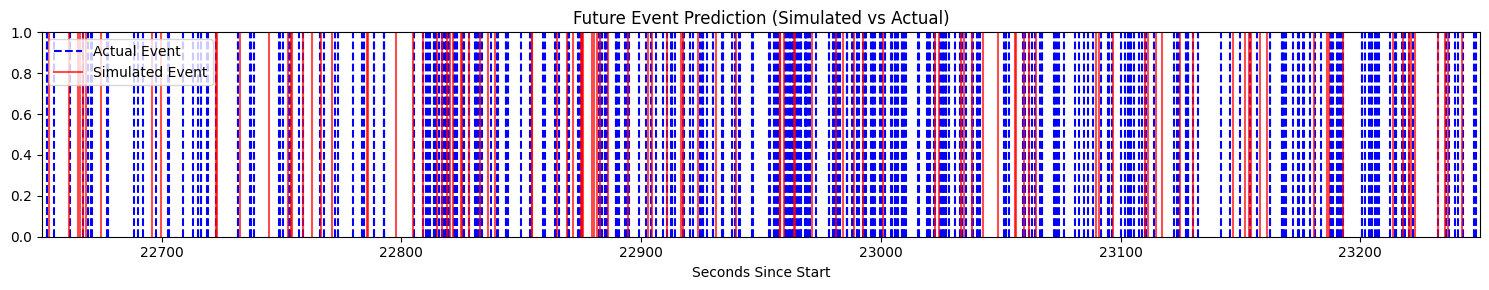

In [110]:
def simulate_hawkes_with_history(mu, alpha, beta, T_future, past_events):
    """
    Simulate future Hawkes events from T to T + T_future given past events.
    """
    simulated = []
    t = 0
    history = np.array(past_events)

    while t < T_future:
        λ_t = mu + np.sum(alpha * np.exp(-beta * (t + past_events[-1] - history[history < (t + past_events[-1])])))
        u = np.random.uniform()
        w = -np.log(u) / λ_t
        t += w
        D = np.random.uniform()
        actual_λ = mu + np.sum(alpha * np.exp(-beta * (t + past_events[-1] - history[history < (t + past_events[-1])])))
        if D <= actual_λ / λ_t and t < T_future:
            simulated.append(t + past_events[-1])
    return np.array(simulated)

T_future = 600  # Predict 10 minutes into the future
T_current = df['seconds_since_start'].iloc[-T_future]  # Last timestamp in your window

simulated_future_events = simulate_hawkes_with_history(
    mu_hat, alpha_hat, beta_hat, T_future=T_future, past_events=event_times[event_times <= T_current]
)

fig, ax = plt.subplots(figsize=(15, 3))
ax.set_title("Future Event Prediction (Simulated vs Actual)")
ax.set_xlim(T_current, T_current + T_future)

# Real events
actual_future_events = df['seconds_since_start'][
    (df['seconds_since_start'] > T_current) & 
    (df['seconds_since_start'] <= T_current + T_future) & 
    event_mask
].values

for t in actual_future_events:
    ax.axvline(t, color='blue', linestyle='--', label='Actual Event' if 'Actual Event' not in ax.get_legend_handles_labels()[1] else "")

# Simulated events
for t in simulated_future_events:
    ax.axvline(t, color='red', linestyle='-', alpha=0.7, label='Simulated Event' if 'Simulated Event' not in ax.get_legend_handles_labels()[1] else "")

ax.legend()
ax.set_xlabel("Seconds Since Start")
plt.tight_layout()
plt.show()


In [111]:
def match_events(predicted, actual, tolerance=1.0):
    """
    Match predicted events to actual events using a time tolerance window.
    Returns true positives, false positives, false negatives.
    """
    predicted = np.sort(predicted)
    actual = np.sort(actual)
    matched_pred = set()
    matched_act = set()

    for i, act in enumerate(actual):
        for j, pred in enumerate(predicted):
            if j in matched_pred:
                continue
            if abs(act - pred) <= tolerance:
                matched_pred.add(j)
                matched_act.add(i)
                break

    TP = len(matched_act)
    FP = len(predicted) - len(matched_pred)
    FN = len(actual) - len(matched_act)
    TN = 0  # TN not well-defined in continuous-time point process

    return TP, FP, FN

TP, FP, FN = match_events(simulated_future_events, actual_future_events, tolerance=1.0)

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

matched_percentage_actual = TP / len(actual_future_events) * 100 if len(actual_future_events) > 0 else 0
print(f"Matched % of actual events: {matched_percentage_actual:.2f}%")


True Positives (TP): 74
False Positives (FP): 37
False Negatives (FN): 280
Precision: 0.6667
Recall: 0.2090
F1 Score: 0.3183
Matched % of actual events: 20.90%


**Same prediction and evaluation on CVX**

In [69]:
df.ticker.unique()

array(['AAPL', 'ALGN', 'AMZN', 'APP', 'BIDU', 'CROX', 'CRWV', 'CVX',
       'DIS', 'FTNT', 'GOOG', 'GS', 'HIMS', 'META', 'MGM', 'NVDA', 'TSLA',
       'WFC', 'XOM'], dtype=object)

In [112]:
base_path = r"C:\Users\ershf\Documents\Curvature_Stock_data"
days = ['0519', '0520', '0521', '0522', '0523']

file_path = os.path.join(base_path, f"pandas_df_0521.csv")
df = pd.read_csv(file_path, parse_dates=['close_ts'])

df_cvx = df[df['ticker']=='CVX'].sort_values("close_ts")
start_time = df_cvx['close_ts'].min()
event_times = (df_cvx['close_ts'] - start_time).dt.total_seconds().values
df_cvx.head(20)

,ticker,close_ts,price,ln_price,log_return
45273,CVX,2025-05-21 13:31:07.836966,136.59,4.916984,1.051502
45274,CVX,2025-05-21 13:31:07.839482,136.59,4.916984,1.000000
45275,CVX,2025-05-21 13:31:07.844732,136.59,4.916984,1.000000
45276,CVX,2025-05-21 13:31:07.846655,136.59,4.916984,1.000000
45277,CVX,2025-05-21 13:31:07.846732,136.59,4.916984,1.000000
45278,CVX,2025-05-21 13:31:07.848771,136.59,4.916984,1.000000
45279,CVX,2025-05-21 13:31:07.850000,136.59,4.916984,1.000000
45280,CVX,2025-05-21 13:31:07.850128,136.59,4.916984,1.000000
45281,CVX,2025-05-21 13:31:07.850295,136.59,4.916984,1.000000
45282,CVX,2025-05-21 13:31:07.851000,136.59,4.916984,1.000000


Estimated Parameters:
μ = 0.1129, α = 55.7665, β = 1714.7168


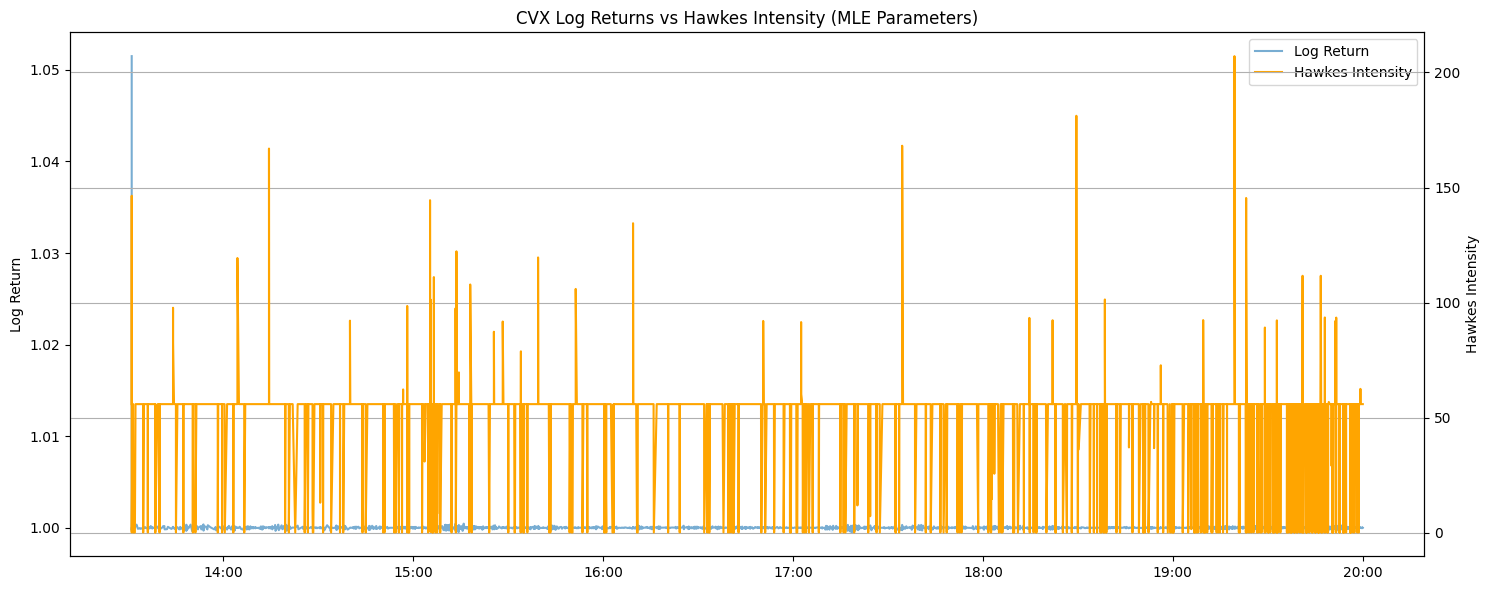

CPU times: total: 40.1 s
Wall time: 41.2 s


In [113]:
%%time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import minimize

# ─────────────── 1. Load AAPL Data ─────────────── #
df = df_cvx.copy()
df['timestamp'] = pd.to_datetime(df['timestamp']) if 'timestamp' in df else pd.to_datetime(df['close_ts'])
df = df.sort_values('timestamp', kind='mergesort').reset_index(drop=True)

start_time = df['timestamp'].iloc[0]
df['seconds_since_start'] = (df['timestamp'] - start_time).dt.total_seconds().astype('float64')
T_max = df['seconds_since_start'].iloc[-1]
grid = df['seconds_since_start'].to_numpy(dtype=float)

# ─────────────── 2. Detect Large Events ─────────────── #
threshold = 0.000001
event_mask = np.abs(df['log_return'] - 1) > threshold
event_times = df['seconds_since_start'][event_mask].values.astype(float)
T = T_max
n = len(event_times)

# ─────────────── 3. MLE: Log-Likelihood Function ─────────────── #
def neg_loglik(params):
    mu, alpha, beta = params
    if mu <= 0 or alpha <= 0 or beta <= 0:
        return np.inf
    ll = 0.0
    for i in range(n):
        past_events = event_times[:i]
        intensity = mu + np.sum(alpha * np.exp(-beta * (event_times[i] - past_events)))
        if intensity <= 0:
            return np.inf
        ll += np.log(intensity)
    comp1 = mu * T
    comp2 = (alpha / beta) * np.sum(1 - np.exp(-beta * (T - event_times)))
    return -(ll - comp1 - comp2)

# ─────────────── 4. Optimize Parameters ─────────────── #
initial_params = [0.1, 0.5, 1.0]
bounds = [(1e-6, None), (1e-6, None), (1e-6, None)]
result = minimize(neg_loglik, initial_params, bounds=bounds, method='L-BFGS-B')
mu_hat, alpha_hat, beta_hat = result.x

print(f"Estimated Parameters:\nμ = {mu_hat:.4f}, α = {alpha_hat:.4f}, β = {beta_hat:.4f}")

# ─────────────── 5. Compute Intensity on Grid (Linear Time) ─────────────── #
def intensity_on_grid_linear(grid, events, mu, alpha, beta):
    grid = np.asarray(grid, dtype=float)
    events = np.asarray(events, dtype=float)
    intens = np.empty_like(grid, dtype=float)
    i_g, i_e = 0, 0
    m = 0.0
    last_t = 0.0
    while i_g < len(grid) or i_e < len(events):
        next_g = grid[i_g] if i_g < len(grid) else np.inf
        next_e = events[i_e] if i_e < len(events) else np.inf
        if next_e <= next_g:
            dt = max(0.0, next_e - last_t)
            m *= np.exp(-beta * dt)
            m += alpha
            last_t = next_e
            i_e += 1
        else:
            dt = max(0.0, next_g - last_t)
            m *= np.exp(-beta * dt)
            intens[i_g] = mu + m
            last_t = next_g
            i_g += 1
    return intens

intensity_values = intensity_on_grid_linear(grid, event_times, mu_hat, alpha_hat, beta_hat)

# ─────────────── 6. Plot: Log Returns + Hawkes Intensity ─────────────── #
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_title("CVX Log Returns vs Hawkes Intensity (MLE Parameters)")
ax1.plot(df['timestamp'], df['log_return'], label='Log Return', alpha=0.6)
ax1.set_ylabel('Log Return')
ax1.tick_params(axis='y')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax2 = ax1.twinx()
ax2.plot(df['timestamp'], intensity_values, label='Hawkes Intensity', color='orange')
ax2.set_ylabel('Hawkes Intensity')
ax2.tick_params(axis='y')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()


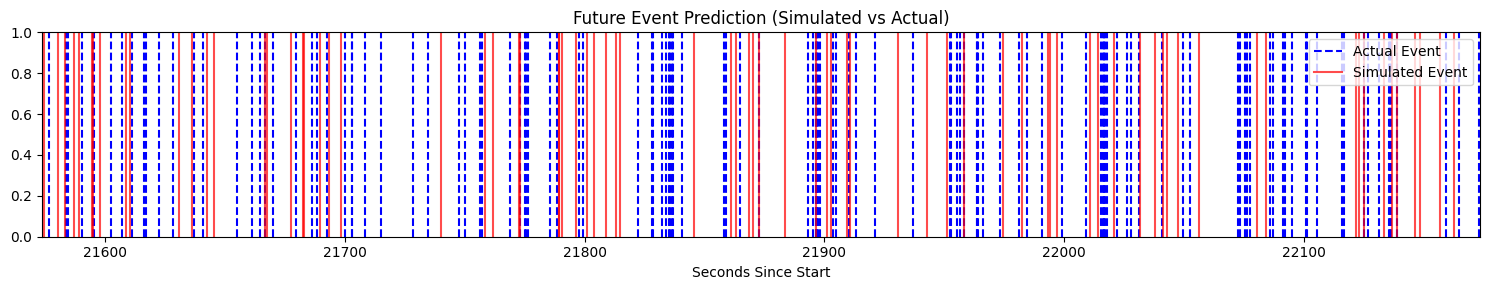

In [114]:
def simulate_hawkes_with_history(mu, alpha, beta, T_future, past_events):
    """
    Simulate future Hawkes events from T to T + T_future given past events.
    """
    simulated = []
    t = 0
    history = np.array(past_events)

    while t < T_future:
        λ_t = mu + np.sum(alpha * np.exp(-beta * (t + past_events[-1] - history[history < (t + past_events[-1])])))
        u = np.random.uniform()
        w = -np.log(u) / λ_t
        t += w
        D = np.random.uniform()
        actual_λ = mu + np.sum(alpha * np.exp(-beta * (t + past_events[-1] - history[history < (t + past_events[-1])])))
        if D <= actual_λ / λ_t and t < T_future:
            simulated.append(t + past_events[-1])
    return np.array(simulated)

T_future = 600  # Predict 10 minutes into the future
T_current = df['seconds_since_start'].iloc[-T_future]  # Last timestamp in your window

simulated_future_events = simulate_hawkes_with_history(
    mu_hat, alpha_hat, beta_hat, T_future=T_future, past_events=event_times[event_times <= T_current]
)

fig, ax = plt.subplots(figsize=(15, 3))
ax.set_title("Future Event Prediction (Simulated vs Actual)")
ax.set_xlim(T_current, T_current + T_future)

# Real events
actual_future_events = df['seconds_since_start'][
    (df['seconds_since_start'] > T_current) & 
    (df['seconds_since_start'] <= T_current + T_future) & 
    event_mask
].values

for t in actual_future_events:
    ax.axvline(t, color='blue', linestyle='--', label='Actual Event' if 'Actual Event' not in ax.get_legend_handles_labels()[1] else "")

# Simulated events
for t in simulated_future_events:
    ax.axvline(t, color='red', linestyle='-', alpha=0.7, label='Simulated Event' if 'Simulated Event' not in ax.get_legend_handles_labels()[1] else "")

ax.legend()
ax.set_xlabel("Seconds Since Start")
plt.tight_layout()
plt.show()


In [115]:
def match_events(predicted, actual, tolerance=1.0):
    """
    Match predicted events to actual events using a time tolerance window.
    Returns true positives, false positives, false negatives.
    """
    predicted = np.sort(predicted)
    actual = np.sort(actual)
    matched_pred = set()
    matched_act = set()

    for i, act in enumerate(actual):
        for j, pred in enumerate(predicted):
            if j in matched_pred:
                continue
            if abs(act - pred) <= tolerance:
                matched_pred.add(j)
                matched_act.add(i)
                break

    TP = len(matched_act)
    FP = len(predicted) - len(matched_pred)
    FN = len(actual) - len(matched_act)
    TN = 0  # TN not well-defined in continuous-time point process

    return TP, FP, FN

TP, FP, FN = match_events(simulated_future_events, actual_future_events, tolerance=1.0)

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

matched_percentage_actual = TP / len(actual_future_events) * 100 if len(actual_future_events) > 0 else 0
print(f"Matched % of actual events: {matched_percentage_actual:.2f}%")


True Positives (TP): 18
False Positives (FP): 60
False Negatives (FN): 106
Precision: 0.2308
Recall: 0.1452
F1 Score: 0.1782
Matched % of actual events: 14.52%


In [ ]:
%%time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import precision_score, recall_score, f1_score
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# ─────────── 1. Load Data ─────────── #
df = df_cvx.copy()
df['timestamp'] = pd.to_datetime(df.get('timestamp', df['close_ts']))
df = df.sort_values('timestamp', kind='mergesort').reset_index(drop=True)
start_time = df['timestamp'].iloc[0]
df['seconds_since_start'] = (df['timestamp'] - start_time).dt.total_seconds()
T_max = df['seconds_since_start'].iloc[-1]
grid = df['seconds_since_start'].to_numpy(dtype=float)

# ─────────── 2. Hawkes MLE Estimation ─────────── #
def fit_hawkes_mle(event_times, T):
    def neg_loglik(params):
        mu, alpha, beta = params
        if mu <= 0 or alpha <= 0 or beta <= 0:
            return np.inf
        ll = 0.0
        for i in range(len(event_times)):
            past_events = event_times[:i]
            intensity = mu + np.sum(alpha * np.exp(-beta * (event_times[i] - past_events)))
            if intensity <= 0:
                return np.inf
            ll += np.log(intensity)
        comp1 = mu * T
        comp2 = (alpha / beta) * np.sum(1 - np.exp(-beta * (T - event_times)))
        return -(ll - comp1 - comp2)

    result = minimize(neg_loglik, [0.1, 0.5, 1.0], bounds=[(1e-6, None)] * 3, method='L-BFGS-B')
    return result.x  # mu_hat, alpha_hat, beta_hat

# ─────────── 3. Simulate Events ─────────── #
def simulate_hawkes(mu, alpha, beta, T):
    simulated = []
    t = 0
    while t < T:
        intensity = mu + np.sum(alpha * np.exp(-beta * (t - np.array(simulated))))
        u = np.random.uniform()
        w = -np.log(u) / intensity
        t += w
        D = np.random.uniform()
        actual_intensity = mu + np.sum(alpha * np.exp(-beta * (t - np.array(simulated))))
        if D <= actual_intensity / intensity:
            simulated.append(t)
    return np.array(simulated)

# ─────────── 4. Match Events with Tolerance ─────────── #
def match_events(actual, predicted, delta=1.0):
    matched = set()
    tp = 0
    for p in predicted:
        match = np.any(np.abs(actual - p) <= delta)
        if match:
            idx = np.argmin(np.abs(actual - p))
            if idx not in matched:
                matched.add(idx)
                tp += 1
    fp = len(predicted) - tp
    fn = len(actual) - tp
    return tp, fp, fn

# ─────────── 5. Scoring Function ─────────── #
@use_named_args([Real(1e-6, 1e-3, prior='log-uniform', name='threshold')])
def score(threshold):
    event_mask = np.abs(df['log_return'] - 1) > threshold
    event_times = df['seconds_since_start'][event_mask].values
    if len(event_times) < 5:
        return 1.0  # high loss
    mu_hat, alpha_hat, beta_hat = fit_hawkes_mle(event_times, T_max)
    pred_events = simulate_hawkes(mu_hat, alpha_hat, beta_hat, T_max)
    actual_future = event_times[event_times > T_max * 0.75]  # e.g., last 25% as test
    pred_future = pred_events[pred_events > T_max * 0.75]
    tp, fp, fn = match_events(actual_future, pred_future, delta=1.0)
    if tp + fp == 0 or tp + fn == 0:
        return 1.0
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    print(f"Thresh: {threshold:.1e}, TP={tp}, FP={fp}, FN={fn}, F1={f1:.4f}")
    return -f1

# ─────────── 6. Optimize Threshold via skopt ─────────── #
res = gp_minimize(score, dimensions=[Real(1e-6, 1e-3, prior='log-uniform', name='threshold')],
                  n_calls=25, random_state=42, verbose=True)

best_thresh = res.x[0]
print(f"\nBest Threshold: {best_thresh:.2e}")

# ─────────── 7. Final Evaluation ─────────── #
final_mask = np.abs(df['log_return'] - 1) > best_thresh
final_events = df['seconds_since_start'][final_mask].values
mu_hat, alpha_hat, beta_hat = fit_hawkes_mle(final_events, T_max)
pred_events = simulate_hawkes(mu_hat, alpha_hat, beta_hat, T_max)

actual_future = final_events[final_events > T_max * 0.75]
pred_future = pred_events[pred_events > T_max * 0.75]
tp, fp, fn = match_events(actual_future, pred_future, delta=1.0)

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall + 1e-10)
matched_pct = 100 * tp / len(actual_future)

print(f"\nFinal Evaluation:")
print(f"TP: {tp}, FP: {fp}, FN: {fn}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
print(f"Matched % of actual events: {matched_pct:.2f}%")


Iteration No: 1 started. Evaluating function at random point.
Thresh: 2.5e-04, TP=0, FP=20, FN=2, F1=0.0000
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.8008
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 2 started. Evaluating function at random point.
Thresh: 3.6e-06, TP=160, FP=447, FN=803, F1=0.2038
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 24.0679
Function value obtained: -0.2038
Current minimum: -0.2038
Iteration No: 3 started. Evaluating function at random point.
Thresh: 2.2e-04, TP=0, FP=15, FN=7, F1=0.0000
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.6858
Function value obtained: -0.0000
Current minimum: -0.2038
Iteration No: 4 started. Evaluating function at random point.
Thresh: 6.2e-05, TP=15, FP=233, FN=331, F1=0.0505
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.9938
Function value obtained: -0.0505
Current minimum: -0.2038
Iteration No: 5 started. E

C:\Users\ershf\NewAnaconda3\envs\hawkes_bayes\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1e-06] before, using random point [4.040432155296039e-06]
  warnings.warn(


Thresh: 4.0e-06, TP=139, FP=455, FN=808, F1=0.1804
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 36.7378
Function value obtained: -0.1804
Current minimum: -0.2098
Iteration No: 13 started. Searching for the next optimal point.


C:\Users\ershf\NewAnaconda3\envs\hawkes_bayes\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1e-06] before, using random point [0.0006569444905905064]
  warnings.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.3723
Function value obtained: 1.0000
Current minimum: -0.2098
Iteration No: 14 started. Searching for the next optimal point.
Thresh: 1.4e-06, TP=161, FP=518, FN=886, F1=0.1866
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 44.5643
Function value obtained: -0.1866
Current minimum: -0.2098
Iteration No: 15 started. Searching for the next optimal point.


C:\Users\ershf\NewAnaconda3\envs\hawkes_bayes\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1e-06] before, using random point [3.2781224251971663e-06]
  warnings.warn(


In [ ]:
2+3

In [80]:
%%time

import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import arviz as az

# ─────────────── 1. Hawkes simulator ─────────────── #
def simulate_hawkes(mu, alpha, beta, T, seed=42):
    rng = np.random.default_rng(seed)
    times, t = [], 0.0
    while t < T:
        past = np.array(times, dtype=float)
        lam = mu + np.sum(alpha * np.exp(-beta * (t - past))) if past.size else mu
        w = -np.log(rng.uniform()) / lam
        t += w
        if t >= T:
            break
        lam_t = mu + np.sum(alpha * np.exp(-beta * (t - past[past < t]))) if past.size else mu
        if rng.uniform() <= lam_t / lam:
            times.append(t)
    return np.array(times, dtype=float)

# ─────────────── 2. Load AAPL data ─────────────── #
df = df_aapl.copy()
df['timestamp'] = pd.to_datetime(df['timestamp']) if 'timestamp' in df else pd.to_datetime(df['close_ts'])
df = df.sort_values('timestamp', kind='mergesort').reset_index(drop=True)

start_time = df['timestamp'].iloc[0]
df['seconds_since_start'] = (df['timestamp'] - start_time).dt.total_seconds().astype('float64')
T_max = float(df['seconds_since_start'].iloc[-1])
grid = df['seconds_since_start'].to_numpy(dtype=float)

# ─────────────── 3. Simulate training events ─────────────── #
TRAIN_WINDOW_SEC = min(15 * 60.0, T_max)
event_times_train = simulate_hawkes(mu=0.3, alpha=0.5, beta=1.0, T=TRAIN_WINDOW_SEC, seed=42)

# Optional: Subsample training events
n_max_events = 300
if len(event_times_train) > n_max_events:
    step = len(event_times_train) // n_max_events
    event_times_train = event_times_train[::step]

# ─────────────── 4. Vectorized log-likelihood ─────────────── #
def hawkes_loglik_vec(mu, alpha, beta, t, T):
    t = pt.as_tensor_variable(t, dtype='float64')
    diffs = t.dimshuffle(0, 'x') - t
    mask = pt.tril(pt.ones_like(diffs), k=-1)
    trig = alpha * pt.exp(-beta * diffs) * mask
    lam_at_events = mu + pt.sum(trig, axis=1)
    lam_at_events = pt.clip(lam_at_events, 1e-3, 1e6)  # Stronger clipping
    log_events = pt.sum(pt.log(lam_at_events))
    compensator = mu * T + pt.sum((alpha / beta) * (1 - pt.exp(-beta * (T - t))))
    return log_events - compensator

# ─────────────── 5. Variational Inference (ADVI with MAP warm-start) ─────────────── #
with pm.Model() as model:
    mu = pm.Lognormal("mu", mu=np.log(0.3), sigma=1.0)
    alpha = pm.Lognormal("alpha", mu=np.log(0.5), sigma=1.0)
    beta = pm.Lognormal("beta", mu=np.log(1.0), sigma=1.0)
    pm.Potential("hawkes_ll", hawkes_loglik_vec(mu, alpha, beta, event_times_train, TRAIN_WINDOW_SEC))
    
    # MAP warm-start to avoid NaNs
    start = pm.find_MAP()
    approx = pm.fit(n=10000, method='advi', start=start, random_seed=42)
    trace = approx.sample(draws=1000)

az.plot_trace(trace, var_names=["mu", "alpha", "beta"])
plt.tight_layout()
plt.show()

# ─────────────── 6. Simulate full-day Hawkes events ─────────────── #
mu_post = trace.posterior["mu"].mean().item()
alpha_post = trace.posterior["alpha"].mean().item()
beta_post = trace.posterior["beta"].mean().item()

event_times_full = simulate_hawkes(mu_post, alpha_post, beta_post, T_max, seed=123)

# ─────────────── 7. Linear-time intensity computation ─────────────── #
def intensity_on_grid_linear(grid, events, mu, alpha, beta):
    grid, events = np.asarray(grid, dtype=float), np.asarray(events, dtype=float)
    intens = np.empty_like(grid)
    i_g, i_e, m, last_t = 0, 0, 0.0, 0.0
    while i_g < len(grid) or i_e < len(events):
        next_g = grid[i_g] if i_g < len(grid) else np.inf
        next_e = events[i_e] if i_e < len(events) else np.inf
        if next_e <= next_g:
            dt = max(0.0, next_e - last_t)
            m *= np.exp(-beta * dt)
            m += alpha
            last_t = next_e
            i_e += 1
        else:
            dt = max(0.0, next_g - last_t)
            m *= np.exp(-beta * dt)
            intens[i_g] = mu + m
            last_t = next_g
            i_g += 1
    return intens

intensity_values = intensity_on_grid_linear(grid, event_times_full, mu_post, alpha_post, beta_post)

# ─────────────── 8. Overlay Plot ─────────────── #
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_title("AAPL Log Returns vs Hawkes Intensity (Posterior Mean Params)")
ax1.plot(df['timestamp'], df['log_return'], label='Log Return', alpha=0.6)
ax1.set_ylabel('Log Return')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax2 = ax1.twinx()
ax2.plot(df['timestamp'], intensity_values, label='Hawkes Intensity', color='orange')
ax2.set_ylabel('Hawkes Intensity', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\ershf\NewAnaconda3\envs\hawkes_bayes\lib\site-packages\pytensor\scalar\basic.py:3098: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
C:\Users\ershf\NewAnaconda3\envs\hawkes_bayes\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'mu_log__': array(-0.7039728), 'alpha_log__': array(-0.19314718), 'beta_log__': array(0.5)}

Logp initial evaluation results:
{'mu': -1.04, 'alpha': -1.04, 'beta': -1.04, 'hawkes_ll': nan}
You can call `model.debug()` for more details.


MAP estimates → mu=0.3162, alpha=0.3274, beta=0.7091

Total forecasted events: 13630
Total real events: 452
Matched events: 140
False positives: 13490
False negatives: 312
Precision: 0.010
Recall: 0.310
F1 Score: 0.020

Confusion Matrix:
 [[35575 10809]
 [  326    89]]


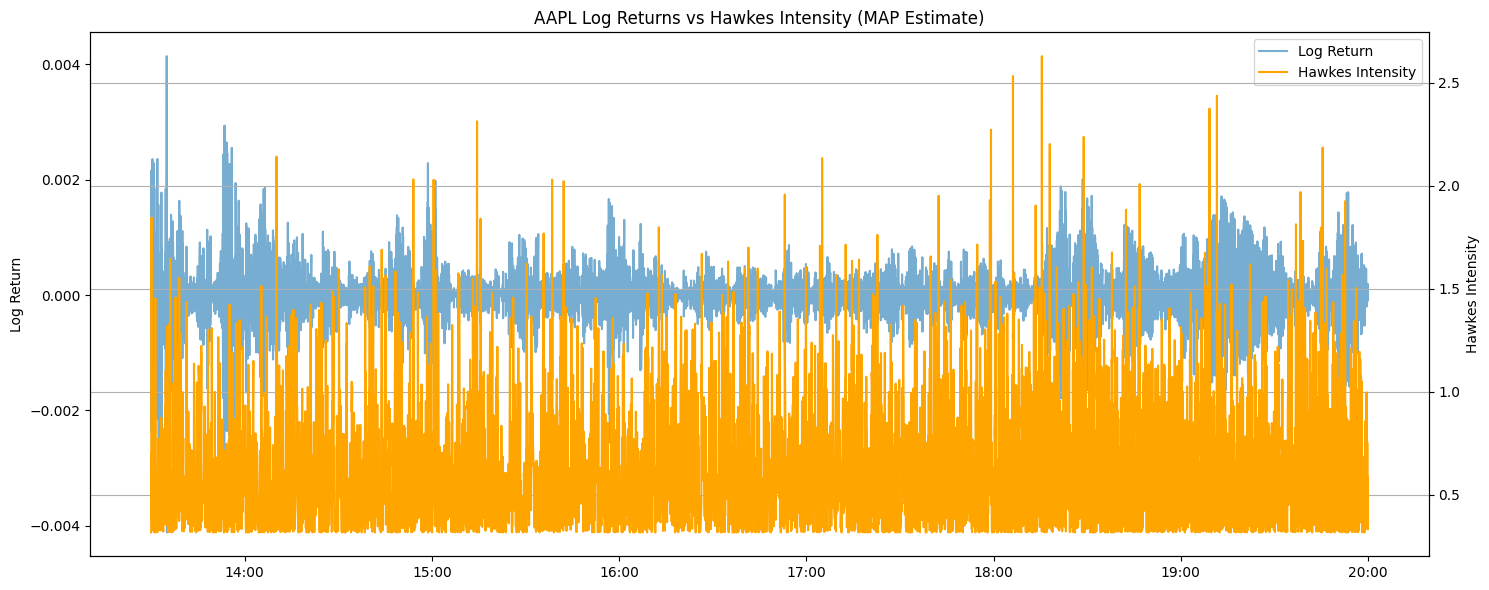

CPU times: total: 24.9 s
Wall time: 29.1 s


In [15]:
%%time

import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# ─────── 1. Hawkes Simulator ─────── #
def simulate_hawkes(mu, alpha, beta, T, seed=42):
    rng = np.random.default_rng(seed)
    times = []
    t = 0.0
    while t < T:
        past = np.array(times, dtype=float)
        lam = mu + np.sum(alpha * np.exp(-beta * (t - past))) if past.size else mu
        w = -np.log(rng.uniform()) / lam
        t += w
        if t >= T:
            break
        lam_t = mu + np.sum(alpha * np.exp(-beta * (t - past[past < t]))) if past.size else mu
        if rng.uniform() <= lam_t / lam:
            times.append(t)
    return np.array(times, dtype=float)

# ─────── 2. Load AAPL Data ─────── #
df = df_aapl.copy()
df['timestamp'] = pd.to_datetime(df['timestamp']) if 'timestamp' in df else pd.to_datetime(df['close_ts'])
df = df.sort_values('timestamp', kind='mergesort').reset_index(drop=True)
start_time = df['timestamp'].iloc[0]
df['seconds_since_start'] = (df['timestamp'] - start_time).dt.total_seconds().astype('float64')
T_max = float(df['seconds_since_start'].iloc[-1])
grid = df['seconds_since_start'].to_numpy(dtype=float)

# ─────── 3. Simulate Events for Training ─────── #
TRAIN_WINDOW_SEC = 60  # 1 minute
event_times_train = simulate_hawkes(mu=0.3, alpha=0.5, beta=1.0, T=TRAIN_WINDOW_SEC, seed=42)

# ─────── 4. Hawkes Log-Likelihood (Vectorized & Clipped) ─────── #
def hawkes_loglik_vec(mu, alpha, beta, t, T):
    t = pt.as_tensor_variable(t, dtype='float64')
    diffs = t.dimshuffle(0, 'x') - t
    mask = pt.tril(pt.ones_like(diffs, dtype='float64'), k=-1)
    trig = alpha * pt.exp(-beta * diffs) * mask
    lam_at_events = mu + pt.sum(trig, axis=1)
    lam_at_events = pt.clip(lam_at_events, 1e-6, 1e6)
    log_events = pt.sum(pt.log(lam_at_events))
    compensator = mu * T + pt.sum((alpha / beta) * (1.0 - pt.exp(-beta * (T - t))))
    return log_events - compensator

# ─────── 5. MAP Estimation ─────── #
with pm.Model() as model:
    mu = pm.HalfNormal("mu", sigma=0.5)
    alpha = pm.HalfNormal("alpha", sigma=0.5)
    beta = pm.HalfNormal("beta", sigma=0.5)
    pm.Potential("hawkes_ll", hawkes_loglik_vec(mu, alpha, beta, event_times_train, TRAIN_WINDOW_SEC))
    map_estimate = pm.find_MAP()

mu_post = map_estimate["mu"]
alpha_post = map_estimate["alpha"]
beta_post = map_estimate["beta"]

print(f"MAP estimates → mu={mu_post:.4f}, alpha={alpha_post:.4f}, beta={beta_post:.4f}")

# ─────── 6. Simulate Full-Day Events ─────── #
event_times_full = simulate_hawkes(mu_post, alpha_post, beta_post, T_max, seed=123)

# ─────── 7. Compute Intensity Over AAPL Timestamps ─────── #
def intensity_on_grid_linear(grid, events, mu, alpha, beta):
    grid = np.asarray(grid, dtype=float)
    events = np.asarray(events, dtype=float)
    intens = np.empty_like(grid, dtype=float)
    i_g, i_e = 0, 0
    m = 0.0
    last_t = 0.0
    while i_g < len(grid) or i_e < len(events):
        next_g = grid[i_g] if i_g < len(grid) else np.inf
        next_e = events[i_e] if i_e < len(events) else np.inf
        if next_e <= next_g:
            dt = max(0.0, next_e - last_t)
            m *= np.exp(-beta * dt)
            m += alpha
            last_t = next_e
            i_e += 1
        else:
            dt = max(0.0, next_g - last_t)
            m *= np.exp(-beta * dt)
            intens[i_g] = mu + m
            last_t = next_g
            i_g += 1
    return intens

intensity_values = intensity_on_grid_linear(grid, event_times_full, mu_post, alpha_post, beta_post)

# ─────── 8. Match Events and Compute Precision/Recall ─────── #
real_event_times = df.loc[df['log_return'].abs() > 0.001, 'seconds_since_start'].values
forecasted_times = event_times_full

delta = 0.5  # seconds window for matching
matched = []
used_real = set()

for f in forecasted_times:
    for r in real_event_times:
        if abs(f - r) <= delta and r not in used_real:
            matched.append((f, r))
            used_real.add(r)
            break

matched_forecasted = set(f for f, _ in matched)
matched_real = set(r for _, r in matched)

TP = len(matched)
FP = len(forecasted_times) - TP
FN = len(real_event_times) - len(matched_real)

precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

print(f"\nTotal forecasted events: {len(forecasted_times)}")
print(f"Total real events: {len(real_event_times)}")
print(f"Matched events: {TP}")
print(f"False positives: {FP}")
print(f"False negatives: {FN}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Optional confusion matrix (binned time series classification)
bin_size = 0.5
edges = np.arange(0, T_max + bin_size, bin_size)
real_binned = np.histogram(real_event_times, bins=edges)[0] > 0
pred_binned = np.histogram(forecasted_times, bins=edges)[0] > 0
cm = confusion_matrix(real_binned, pred_binned)
print("\nConfusion Matrix:\n", cm)

# ─────── 9. Plot ─────── #
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_title("AAPL Log Returns vs Hawkes Intensity (MAP Estimate)")
ax1.plot(df['timestamp'], df['log_return'], label='Log Return', alpha=0.6)
ax1.set_ylabel('Log Return')
ax1.tick_params(axis='y')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax2 = ax1.twinx()
ax2.plot(df['timestamp'], intensity_values, label='Hawkes Intensity', color='orange')
ax2.set_ylabel('Hawkes Intensity')
ax2.tick_params(axis='y')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
%%time

import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# ─────── 1. Hawkes Simulator ─────── #
def simulate_hawkes(mu, alpha, beta, T, seed=42):
    rng = np.random.default_rng(seed)
    times = []
    t = 0.0
    while t < T:
        past = np.array(times, dtype=float)
        lam = mu + np.sum(alpha * np.exp(-beta * (t - past))) if past.size else mu
        w = -np.log(rng.uniform()) / lam
        t += w
        if t >= T:
            break
        lam_t = mu + np.sum(alpha * np.exp(-beta * (t - past[past < t]))) if past.size else mu
        if rng.uniform() <= lam_t / lam:
            times.append(t)
    return np.array(times, dtype=float)

# ─────── 2. Load AAPL Data ─────── #
df = df_aapl.copy()
df['timestamp'] = pd.to_datetime(df['timestamp']) if 'timestamp' in df else pd.to_datetime(df['close_ts'])
df = df.sort_values('timestamp').reset_index(drop=True)
start_time = df['timestamp'].iloc[0]
df['seconds_since_start'] = (df['timestamp'] - start_time).dt.total_seconds()
T_max = df['seconds_since_start'].iloc[-1]
grid = df['seconds_since_start'].values

# ─────── 3. Extract Real Spike Events for Training ─────── #
threshold = 0.001
event_times_train = df.loc[df['log_return'].abs() > threshold, 'seconds_since_start'].values
print(f"Training on {len(event_times_train)} real AAPL events (log_return > {threshold})")

# ─────── 4. Hawkes Log-Likelihood ─────── #
def hawkes_loglik_vec(mu, alpha, beta, t, T):
    t = pt.as_tensor_variable(t, dtype='float64')
    diffs = t.dimshuffle(0, 'x') - t
    mask = pt.tril(pt.ones_like(diffs, dtype='float64'), k=-1)
    trig = alpha * pt.exp(-beta * diffs) * mask
    lam_at_events = mu + pt.sum(trig, axis=1)
    lam_at_events = pt.clip(lam_at_events, 1e-6, 1e6)
    log_events = pt.sum(pt.log(lam_at_events))
    compensator = mu * T + pt.sum((alpha / beta) * (1.0 - pt.exp(-beta * (T - t))))
    return log_events - compensator

# ─────── 5. MAP Estimation ─────── #
with pm.Model() as model:
    mu = pm.HalfNormal("mu", sigma=0.5)
    alpha = pm.HalfNormal("alpha", sigma=0.5)
    beta = pm.HalfNormal("beta", sigma=0.5)
    pm.Potential("hawkes_ll", hawkes_loglik_vec(mu, alpha, beta, event_times_train, T_max))
    map_estimate = pm.find_MAP()

mu_post = map_estimate["mu"]
alpha_post = map_estimate["alpha"]
beta_post = map_estimate["beta"]
print(f"\nMAP estimates → mu={mu_post:.4f}, alpha={alpha_post:.4f}, beta={beta_post:.4f}")

# ─────── 6. Simulate Forecasted Events ─────── #
event_times_forecasted = simulate_hawkes(mu_post, alpha_post, beta_post, T_max, seed=123)

# ─────── 7. Intensity Computation ─────── #
def intensity_on_grid_linear(grid, events, mu, alpha, beta):
    grid = np.asarray(grid, dtype=float)
    events = np.asarray(events, dtype=float)
    intens = np.empty_like(grid, dtype=float)
    i_g, i_e = 0, 0
    m = 0.0
    last_t = 0.0
    while i_g < len(grid) or i_e < len(events):
        next_g = grid[i_g] if i_g < len(grid) else np.inf
        next_e = events[i_e] if i_e < len(events) else np.inf
        if next_e <= next_g:
            dt = max(0.0, next_e - last_t)
            m *= np.exp(-beta * dt)
            m += alpha
            last_t = next_e
            i_e += 1
        else:
            dt = max(0.0, next_g - last_t)
            m *= np.exp(-beta * dt)
            intens[i_g] = mu + m
            last_t = next_g
            i_g += 1
    return intens

intensity_values = intensity_on_grid_linear(grid, event_times_forecasted, mu_post, alpha_post, beta_post)

# ─────── 8. Match Events and Evaluate ─────── #
real_event_times = df.loc[df['log_return'].abs() > threshold, 'seconds_since_start'].values
delta = 0.5
matched = []
used_real = set()

for f in event_times_forecasted:
    for r in real_event_times:
        if abs(f - r) <= delta and r not in used_real:
            matched.append((f, r))
            used_real.add(r)
            break

matched_forecasted = set(f for f, _ in matched)
matched_real = set(r for _, r in matched)

TP = len(matched)
FP = len(event_times_forecasted) - TP
FN = len(real_event_times) - len(matched_real)

precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

print(f"\nTotal forecasted events: {len(event_times_forecasted)}")
print(f"Total real events: {len(real_event_times)}")
print(f"Matched events: {TP}")
print(f"False positives: {FP}")
print(f"False negatives: {FN}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Confusion Matrix
bin_size = 0.5
edges = np.arange(0, T_max + bin_size, bin_size)
real_binned = np.histogram(real_event_times, bins=edges)[0] > 0
pred_binned = np.histogram(event_times_forecasted, bins=edges)[0] > 0
cm = confusion_matrix(real_binned, pred_binned)
print("\nConfusion Matrix:\n", cm)

# ─────── 9. Plot ─────── #
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_title("AAPL Log Returns vs Hawkes Intensity (Trained on Real Spikes)")
ax1.plot(df['timestamp'], df['log_return'], label='Log Return', alpha=0.6)
ax1.set_ylabel('Log Return')
ax1.tick_params(axis='y')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax2 = ax1.twinx()
ax2.plot(df['timestamp'], intensity_values, label='Hawkes Intensity', color='orange')
ax2.set_ylabel('Hawkes Intensity')
ax2.tick_params(axis='y')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()


Training on 15885 real AAPL events (log_return > 0.001)


C:\Users\ershf\NewAnaconda3\envs\hawkes_bayes\lib\site-packages\pytensor\scalar\basic.py:3098: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
C:\Users\ershf\NewAnaconda3\envs\hawkes_bayes\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


KeyboardInterrupt: 

In [41]:
%%time

import numpy as np
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt

# ─────────────── Load Real AAPL Event Data ─────────────── #
# Replace this with your actual high-frequency AAPL timestamps (in seconds or ms)
df_aapl = pd.read_csv("real_aapl_event_times.csv")  # Must have a column 'timestamp'
df_aapl = df_aapl.sort_values('timestamp')
event_times = df_aapl['timestamp'].to_numpy()
event_times = (event_times - event_times.min()) / 1_000_000  # Normalize to seconds
T_max = event_times.max()

# ─────────────── Hawkes Log-Likelihood ─────────────── #
def hawkes_logp(event_times, mu, alpha, beta, T):
    n_events = event_times.shape[0]

    # Compute pairwise differences between events (lower triangle only)
    diffs = event_times[None, :] - event_times[:, None]
    mask = pt.tril(pt.ones((n_events, n_events), dtype="bool"), k=-1)
    dt = pt.switch(mask, diffs, 0.0)  # Only keep dt > 0

    # Decay contributions from past events
    exp_decay = pt.exp(-beta * dt) * mask
    excitation_sum = pt.sum(exp_decay, axis=1)

    # Safe intensity and log-likelihood
    epsilon = 1e-6
    intensity = pt.clip(mu + alpha * excitation_sum, epsilon, 1e6)
    log_likelihood = pt.sum(pt.log(intensity))

    # Integral of intensity
    decay_integral = pt.clip(1 - pt.exp(-beta * (T - event_times)), 0, 1)
    integral = mu * T + (alpha / beta) * pt.sum(decay_integral)

    return log_likelihood - integral

# ─────────────── Bayesian Inference with PyMC ─────────────── #
with pm.Model() as hawkes_model:
    mu = pm.HalfNormal("mu", sigma=1.0)
    alpha = pm.HalfNormal("alpha", sigma=1.0)
    beta = pm.HalfNormal("beta", sigma=1.0)

    ll = pm.Potential("hawkes_ll", hawkes_logp(event_times, mu, alpha, beta, T_max))
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9)

# ─────────────── Plot Posterior Distributions ─────────────── #
az.plot_trace(trace, var_names=["mu", "alpha", "beta"])
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'real_aapl_event_times.csv'

In [20]:
%%time

import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import matplotlib.pyplot as plt
from datetime import timedelta

# ─────── Load and Filter AAPL Trade Data ───────
df = df_aapl.copy()
df['timestamp'] = pd.to_datetime(df['close_ts'])
df = df.sort_values('timestamp')
df = df[df['timestamp'].dt.date == pd.to_datetime('2025-05-20').date()]

# 10-minute analysis window
start_ts = df['timestamp'].min()
end_ts = start_ts + timedelta(minutes=60)
events = df[(df['timestamp'] >= start_ts) & (df['timestamp'] < end_ts)]['timestamp']
events_seconds = (events - start_ts).dt.total_seconds().values.astype("float64")

# ─────── Safe Exit If No Events ───────
if len(events_seconds) == 0:
    raise ValueError("No events found in the specified time window.")

# Downsample if necessary
if len(events_seconds) > 3000:
    events_seconds = np.sort(np.random.choice(events_seconds, 3000, replace=False))

T_value = float(events_seconds.max())

# ─────── Hawkes Log Likelihood Without at.triu ───────
def hawkes_log_likelihood(mu, alpha, beta, events, T):
    lambda_terms = []
    n = events.shape[0]

    for i in range(n):
        ti = events[i]
        triggering = at.sum(alpha * at.exp(-beta * (ti - events[:i])))
        intensity = mu + triggering
        lambda_terms.append(at.log(intensity))

    log_lambda_sum = at.sum(at.stack(lambda_terms))
    compensator = mu * T + at.sum((alpha / beta) * (1 - at.exp(-beta * (T - events))))
    return log_lambda_sum - compensator

# ─────── Bayesian Inference ───────
with pm.Model() as model:
    mu = pm.HalfNormal("mu", sigma=2.0)
    alpha = pm.HalfNormal("alpha", sigma=2.0)
    beta = pm.HalfNormal("beta", sigma=2.0)

    obs = pm.Potential("obs", hawkes_log_likelihood(
        mu, alpha, beta,
        at.as_tensor_variable(events_seconds, dtype="float64"),
        T_value
    ))

    trace = pm.sample(1000, tune=1000, target_accept=0.9, chains=2, random_seed=42)

# ─────── Posterior Plots ───────
pm.plot_posterior(trace, var_names=["mu", "alpha", "beta"])
plt.tight_layout()
plt.show()

# ─────── Predictive Intensity Plot ───────
def plot_intensity(trace, events, T, num_samples=50):
    t_grid = np.linspace(0, T, 1000)
    intensity_samples = []

    trace_df = trace.posterior.stack(sample=("chain", "draw"))

    for i in np.random.choice(trace_df.sample.size, size=num_samples, replace=False):
        mu_ = trace_df['mu'].values[i]
        alpha_ = trace_df['alpha'].values[i]
        beta_ = trace_df['beta'].values[i]

        lambda_t = np.full_like(t_grid, mu_, dtype=float)
        for t_i in events:
            lambda_t += alpha_ * np.exp(-beta_ * (t_grid - t_i)) * (t_grid > t_i)
        intensity_samples.append(lambda_t)

    intensity_samples = np.array(intensity_samples)
    plt.fill_between(t_grid, np.percentile(intensity_samples, 5, axis=0),
                     np.percentile(intensity_samples, 95, axis=0), alpha=0.3)
    plt.plot(t_grid, np.mean(intensity_samples, axis=0), label='Posterior Mean Intensity')
    plt.xlabel("Time (sec)")
    plt.ylabel("λ(t)")
    plt.title("Posterior Predictive Intensity")
    plt.legend()
    plt.show()

plot_intensity(trace, events_seconds, T_value)


WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


NameError: name 'hawkes_log_likelihood' is not defined

In [69]:
import numpy as np
import pandas as pd
from datetime import timedelta
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ─────── Load AAPL Events ───────
df = df_aapl.copy()
df['timestamp'] = pd.to_datetime(df['close_ts'])
df = df[df['timestamp'].dt.date == pd.to_datetime("2025-05-20").date()]
df = df.sort_values("timestamp")

start_ts = df['timestamp'].min()
end_ts = start_ts + timedelta(minutes=10)
events = df[(df['timestamp'] >= start_ts) & (df['timestamp'] < end_ts)]['timestamp']
event_times = (events - start_ts).dt.total_seconds().values
event_times = event_times[event_times > 0.0]  # remove 0.0 if present
event_times = np.sort(event_times)

T = float(event_times.max())

# ─────── Ogata Log-Likelihood ───────
def neg_log_likelihood(params, events, T):
    mu, alpha, beta = params
    if mu <= 0 or alpha <= 0 or beta <= 0:
        return np.inf

    n = len(events)
    compensator = mu * T + (alpha / beta) * np.sum(1 - np.exp(-beta * (T - events)))

    intensity = np.zeros(n)
    for i in range(n):
        history = events[:i]
        if len(history) > 0:
            intensity[i] = mu + np.sum(alpha * np.exp(-beta * (events[i] - history)))
        else:
            intensity[i] = mu

    log_likelihood = np.sum(np.log(intensity)) - compensator
    return -log_likelihood  # negative for minimization

# ─────── Optimize ───────
init_params = np.array([0.05, 0.5, 1.0])  # mu, alpha, beta
bounds = [(1e-6, None), (1e-6, None), (1e-6, None)]

res = minimize(neg_log_likelihood, init_params, args=(event_times, T), bounds=bounds)

mu_hat, alpha_hat, beta_hat = res.x
print(f"Estimated mu: {mu_hat:.4f}, alpha: {alpha_hat:.4f}, beta: {beta_hat:.4f}")


Estimated mu: 0.6482, alpha: 1750.1603, beta: 1944.4471


Mean Squared Error between predicted λ(t) and smoothed actual: 2633.7082


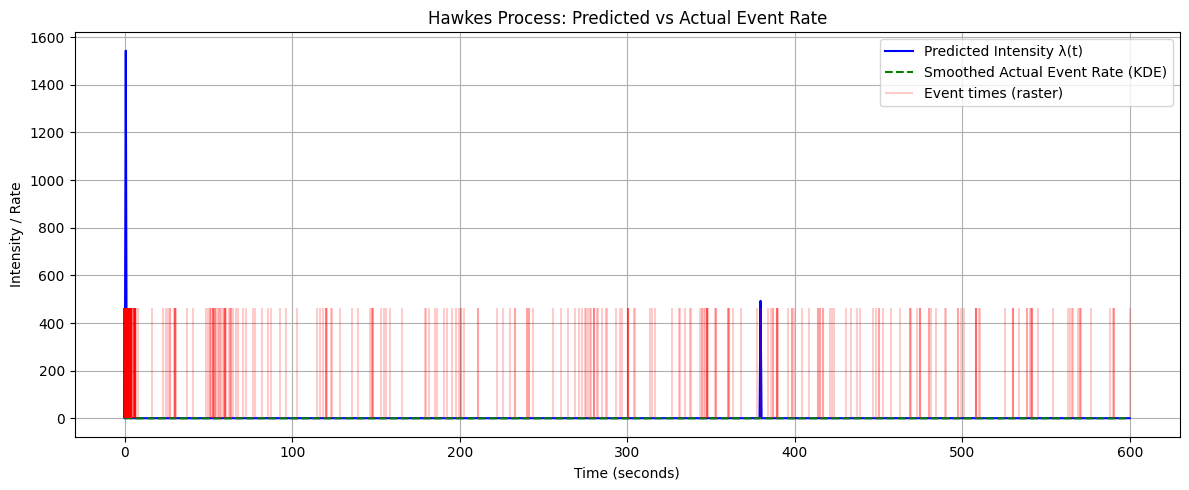

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error

# ───── Constants ─────
mu, alpha, beta = mu_hat, alpha_hat, beta_hat
T = float(event_times.max())
n_grid = 1000
grid_times = np.linspace(0, T, n_grid)

# ───── Predict λ(t) at each grid point ─────
lambda_t = np.zeros_like(grid_times)
for i, t in enumerate(grid_times):
    past_events = event_times[event_times < t]
    if len(past_events) > 0:
        lambda_t[i] = mu + np.sum(alpha * np.exp(-beta * (t - past_events)))
    else:
        lambda_t[i] = mu

# ───── Kernel Density Estimate of Actual Event Rate ─────
kde = gaussian_kde(event_times, bw_method=0.01)
true_rate = kde(grid_times)

# ───── Evaluation ─────
mse = mean_squared_error(true_rate, lambda_t)
print(f"Mean Squared Error between predicted λ(t) and smoothed actual: {mse:.4f}")

# ───── Visualization ─────
plt.figure(figsize=(12, 5))
plt.plot(grid_times, lambda_t, label="Predicted Intensity λ(t)", color='blue')
plt.plot(grid_times, true_rate, label="Smoothed Actual Event Rate (KDE)", color='green', linestyle="--")
plt.vlines(event_times, ymin=0, ymax=max(lambda_t)*0.3, color='red', alpha=0.2, label="Event times (raster)")
plt.xlabel("Time (seconds)")
plt.ylabel("Intensity / Rate")
plt.title("Hawkes Process: Predicted vs Actual Event Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import binned_statistic

# ─── CONFIG ───
bin_width = 1.0  # 1 second bin
threshold_percentile = 90  # threshold for predicted lambda(t)
T = 600  # Observation window in seconds (set to max(events) if unsure)
mu_est, alpha_est, beta_est = 0.6482, 1750.1603, 1944.4471  # Use your fitted params
events = np.array(events)  # Your filtered event times (no zero)

# ─── Binarize Ground Truth ───
time_bins = np.arange(0, T + bin_width, bin_width)
y_true, _, _ = binned_statistic(events, np.ones_like(events), statistic='sum', bins=time_bins)
y_true = (y_true > 0).astype(int)

# ─── Predict λ(t) on Bin Centers ───
bin_centers = time_bins[:-1] + bin_width / 2
lambda_pred = mu_est + np.sum([
    alpha_est * np.exp(-beta_est * (bin_centers - t)) * (bin_centers >= t)
    for t in events
], axis=0)

# ─── Threshold λ(t) to Get Binary Predictions ───
threshold = np.percentile(lambda_pred, threshold_percentile)
y_pred = (lambda_pred > threshold).astype(int)

# ─── Evaluation Metrics ───
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, digits=4)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# ─── Visualization ───
plt.figure(figsize=(12, 5))
plt.plot(bin_centers, y_true, label='Actual (1 if event)', alpha=0.7)
plt.plot(bin_centers, y_pred, label=f'Predicted (λ > {threshold:.1f})', alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Event Presence (Binary)")
plt.legend()
plt.title("Hawkes Process: Event Prediction as Binary Classification")
plt.grid(True)
plt.tight_layout()
plt.show()


TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>)